# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DuelingQNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        nn.Module.__init__(self)
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3_a = nn.Linear(fc2_units, action_size)
        self.fc3_v = nn.Linear(fc2_units, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        V = self.fc3_v(x)
        A = self.fc3_a(x)
        A = A - A.mean(1).unsqueeze(1)
        Q = V + A
        return Q

In [1]:
import sys
sys.path.append('..')
from baselines.common.segment_tree import *
from baselines.deepq.replay_buffer import ReplayBuffer, PrioritizedReplayBuffer

import numpy as np
import random
from collections import namedtuple, deque

BUFFER_SIZE = int(1e5)         # replay buffer size
BATCH_SIZE = 64                # minibatch size
GAMMA = 0.99                   # discount factor
TAU = 1e-3                     # for soft update of target parameters
LR = 5e-4                      # learning rate 
UPDATE_EVERY = 4               # how often to update the network
PRIORITIZED_REPLAY_EPS = 1e-7  # prioritized replay eps

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LinearSchedule():
    
    def __init__(self, vals, steps):
        assert len(steps) == len(vals)
        for step in steps:
            assert isinstance(step, int)
            assert step >= 0
        assert steps[0] == 0
        for i in range(1,len(steps)):
            assert steps[i] > steps[i-1]
            
        self.vals = vals
        self.steps = steps
        self.eps = 0
        self.findex = 0
        self.f = []
        for i in range(1,len(self.steps)):
            s1, s0 = self.steps[i], self.steps[i-1]
            v1, v0 = self.vals[i], self.vals[i-1]
            ramp = (v1-v0)/(s1-s0)
            self.f.append(lambda e, ramp=ramp, s0=s0, v0=v0: v0+(e-s0)*ramp)            
        self.f.append(lambda e: self.vals[-1])
        
    def __call__(self, done=False):
        val = self.f[self.findex](self.eps)
        if done:
            self.eps += 1
            if self.findex < len(self.f)-1:
                if self.eps >= self.steps[self.findex+1]:
                    self.findex += 1
        return val


class DoubleDuelingQAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = PrioritizedReplayBuffer(BUFFER_SIZE, 1e-5)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        # Schedules for alpha and beta parameters
        #self.alpha = LinearSchedule([0.0, 0.0], [0, 1])        
        #self.beta = LinearSchedule([1e-5, 1e-5], [0, 1])
        #self.alpha = LinearSchedule([1e-6, 1e-6, 0.6], [0, 150, 200])        
        #self.beta = LinearSchedule([1e-3, 1e-2, 0.3, 0.5], [0, 100, 200, 300])           
        self.alpha = LinearSchedule([1.0, 1.0, 0.6], [0, 300, 500])        
        self.beta = LinearSchedule([1.0, 1.0, 0.4], [0, 300, 500])
        
    def step(self, state, action, reward, next_state, done):        
        idx = self.memory._next_idx
        
        # Add sample buffer to replay memory
        self.memory.add(state, action, reward, next_state, done)
        states = np.expand_dims(state, axis=0)
        actions = np.expand_dims(np.expand_dims(action, axis=0), axis=-1)
        rewards = np.expand_dims(reward, axis=0)        
        next_states = np.expand_dims(next_state, axis=0)        
        dones = np.expand_dims(done, axis=0)
        
        delta = self.compute_delta(states, actions, rewards, next_states, dones, GAMMA)
        priorities = np.abs(np.squeeze(delta.cpu().detach().numpy(), axis=0)) + PRIORITIZED_REPLAY_EPS
        self.memory.update_priorities([idx], priorities)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            
          
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(BATCH_SIZE, self.beta(done))
                self.memory.alpha = self.alpha(done)
                self.learn(experiences, GAMMA)
                               
                
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            actions_local = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(actions_local.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def compute_delta(self, states, actions, rewards, next_states, dones, gamma):
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones.astype(np.uint8)).float().to(device)
        
        # Get max predicted Q values (for next states) from target model
        # Double DQN
        actions_next_state = self.qnetwork_local(states).detach().argmax(1).unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, actions_next_state)
        # DQN
        # Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss
        delta = Q_targets - Q_expected
        
        return delta

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """        
        states, actions, rewards, next_states, dones, weights, indices = experiences
        
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(np.expand_dims(actions, axis=-1)).long().to(device)
        rewards = torch.from_numpy(np.expand_dims(rewards, axis=-1)).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(np.expand_dims(dones.astype(np.uint8), axis=-1)).float().to(device)        
        weights = torch.from_numpy(weights).float().to(device)

        # Get max predicted Q values (for next states) from target model
        # Double DQN
        actions_next_state = self.qnetwork_local(states).detach().argmax(1).unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, actions_next_state)
        # DQN
        # Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss
        delta = Q_targets - Q_expected
        squared_difference = delta ** 2
        weighted_squared_difference = weights * squared_difference
        loss = weighted_squared_difference.mean()
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 

        # ------------------- update priorities ------------------- #        
        new_priorities = np.abs(np.squeeze(delta.cpu().detach().numpy())) + PRIORITIZED_REPLAY_EPS
        self.memory.update_priorities(indices, new_priorities)
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

NameError: name 'torch' is not defined

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

ModuleNotFoundError: No module named 'unityagents'

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)

agent = DoubleDuelingQAgent(state_size=state_size, action_size=action_size, seed=0)

Episode 100	Average Score: 0.00
Episode 200	Average Score: 2.99
Episode 300	Average Score: 7.44
Episode 400	Average Score: 9.985
Episode 500	Average Score: 11.85
Episode 530	Average Score: 13.03
Environment solved in 430 episodes!	Average Score: 13.03
time = 807.74 s


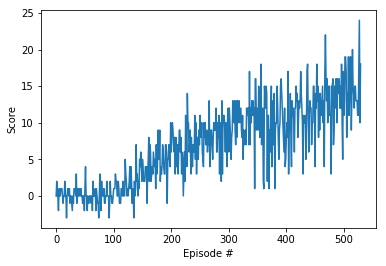

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished       
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

import time
start = time.time()
scores = dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)
end = time.time()
print('time = {:.2f} s'.format(end-start))

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

# Close the environment
env.close()